In [1]:
import os, pandas as pd, requests

DATA_RAW = "../data/raw"
DATA_INTERIM = "../data/interim"
os.makedirs(DATA_RAW, exist_ok=True)
os.makedirs(DATA_INTERIM, exist_ok=True)

In [2]:
from io import StringIO

# Paths
DATA_RAW = "../data/raw"
os.makedirs(DATA_RAW, exist_ok=True)

# API endpoint
base_url = "https://ffiec.cfpb.gov/v2/data-browser-api/view/csv"

params = {
    "years": "2022",
    "states": "CA",
    "loanTypes": "1",      # conventional
    "propertyTypes": "1",  # 1–4 family, site-built
    "occupancyTypes": "1", # primary
    "lienStatuses": "1",    # first lien
    "loan_purposes": "1",    # purchase loans
    "action_taken": "1,2,3,8"  # include denials
}

# Add User-Agent header to avoid 403
headers = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
                  "(KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36"
}

resp = requests.get(base_url, params=params, headers=headers)
resp.raise_for_status()

# Read CSV from response 
df_raw = pd.read_csv(StringIO(resp.text), low_memory=False)

# Save raw pull
raw_out = os.path.join(DATA_RAW, "hmda_ca2022_raw.csv")
df_raw.to_csv(raw_out, index=False)

print("Rows, Cols:", df_raw.shape)
df_raw.head(3)

Rows, Cols: (611698, 99)


,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2022,549300FGXN1K3HLB1R50,40900,CA,6061.0,6.061024e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4361,11.10,102400,97.88,2252,2634,0
1,2022,549300FGXN1K3HLB1R50,40900,CA,6067.0,6.067009e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,8897,54.51,102400,173.83,2287,2568,21
2,2022,549300FGXN1K3HLB1R50,31084,CA,6037.0,6.037481e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4183,57.54,91100,186.97,696,1045,65


In [3]:
print("✅ Full HMDA dataset (with denials) downloaded.")
print(f"Rows: {len(df_raw):,}, Cols: {df_raw.shape[1]}")
print("Action Taken breakdown:")
print(df_raw["action_taken"].value_counts(normalize=True).round(3))

✅ Full HMDA dataset (with denials) downloaded.
Rows: 611,698, Cols: 99
Action Taken breakdown:
action_taken
1    0.572
4    0.154
6    0.135
3    0.077
5    0.026
2    0.026
8    0.007
7    0.002
Name: proportion, dtype: float64


In [4]:
# Schema check
print("Sample columns:", df_raw.columns.tolist()[:20])
print("Years:", df_raw["activity_year"].unique())
print("States:", df_raw["state_code"].unique())
print("Loan Purpose:", df_raw["loan_purpose"].unique())
print("Unique institutions (LEI):", df_raw["lei"].nunique())
print("Approval rate raw:", (df_raw["action_taken"].isin([1, 2]).astype(int).mean().round(3)))

key_cols = ["income","loan_amount","loan_to_value_ratio","rate_spread","debt_to_income_ratio"]
print(df_raw[key_cols].isna().mean().sort_values().rename("null_frac"))

for c in key_cols:
    s = pd.to_numeric(df_raw[c], errors="coerce")
    print(f"{c}: min={s.min()}, median={s.median()}, p95={s.quantile(0.95)}, max={s.max()}")

Sample columns: ['activity_year', 'lei', 'derived_msa-md', 'state_code', 'county_code', 'census_tract', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category', 'derived_ethnicity', 'derived_race', 'derived_sex', 'action_taken', 'purchaser_type', 'preapproval', 'loan_type', 'loan_purpose', 'lien_status', 'reverse_mortgage', 'open-end_line_of_credit']
Years: [2022]
States: ['CA']
Loan Purpose: [1]
Unique institutions (LEI): 1072
Approval rate raw: 0.598
loan_amount             0.000000
income                  0.145959
loan_to_value_ratio     0.352053
debt_to_income_ratio    0.355437
rate_spread             0.458210
Name: null_frac, dtype: float64
income: min=-5309.0, median=148.0, p95=530.0, max=8152154.0
loan_amount: min=5000.0, median=525000.0, p95=1545000.0, max=463005000.0
loan_to_value_ratio: min=0.014, median=80.0, p95=100.0, max=113636.36
rate_spread: min=-8.852, median=0.196, p95=1.896, max=100.0
debt_to_income_ratio: min=36.0, median=43.0, p95=49.0, ma

In [14]:
import numpy as np

DATA_INTERIM = "../data/interim"
os.makedirs(DATA_INTERIM, exist_ok=True)

# From previous cell
cohort = df_raw.copy()

# Convert key numeric columns to numeric
cohort["loan_to_value_ratio"] = pd.to_numeric(cohort["loan_to_value_ratio"], errors="coerce")
cohort["income"] = pd.to_numeric(cohort["income"], errors="coerce")
cohort["loan_amount"] = pd.to_numeric(cohort["loan_amount"], errors="coerce")
cohort["rate_spread"] = pd.to_numeric(cohort["rate_spread"], errors="coerce")

# Convert race and ethnicity indicators to numeric
int_fields = [
    "applicant_race-1", "co-applicant_race-1",
    "applicant_ethnicity-1", "co-applicant_ethnicity-1",
    "applicant_race_observed"
]
for col in int_fields:
    cohort[col] = pd.to_numeric(cohort[col], errors="coerce").astype("Int64")

# Build a new categorical column race_group from raw HMDA codes
def classify_race(row):
    app_race = row["applicant_race-1"]
    co_app_race = row["co-applicant_race-1"]
    app_eth = row["applicant_ethnicity-1"]
    co_app_eth = row["co-applicant_ethnicity-1"]
    app_obs = row["applicant_race_observed"]

    # In cases where the co-applicant is identified as ‘White’ and the applicant is of a different race, we reclassify the applicant’s race as ‘White’ 
    if (pd.notna(app_race) and app_race == 5) or (pd.notna(co_app_race) and co_app_race == 5):
        return "White"

    # Hispanic as a distinct group regardless of race
    if (pd.notna(app_eth) and app_eth in [1, 11, 12, 13, 14]) or \
       (pd.notna(co_app_eth) and co_app_eth in [1, 11, 12, 13, 14]):
        return "Hispanic or Latino"

    # Classify race group based on the primary applicant's race
    if pd.notna(app_race):
        if app_race == 1:
            return "American Indian or Alaska Native"
        if app_race in [2] + list(range(21, 28)):
            return "Asian"
        if app_race == 3:
            return "Black or African American"
        if app_race in [4, 41, 42, 43, 44]:
            return "Pacific Islander"

    # Classify race group based on the primary applicant's race
    if pd.notna(app_obs):
        if app_obs == 1:
            return "American Indian or Alaska Native"
        if app_obs in [2] + list(range(21, 28)):
            return "Asian"
        if app_obs == 3:
            return "Black or African American"
        if app_obs in [4, 41, 42, 43, 44]:
            return "Pacific Islander"

    return "Other / Unknown"

# Apply race classification
cohort["race_group"] = cohort.apply(classify_race, axis=1)

# Remove rows where race can’t be assigned
cohort = cohort[cohort["race_group"] != "Other / Unknown"].copy()

# Replace zero or missing median income with NaN to prevent inf
cohort["ffiec_msa_md_median_family_income"] = pd.to_numeric(
    cohort["ffiec_msa_md_median_family_income"], errors="coerce"
)
cohort.loc[cohort["ffiec_msa_md_median_family_income"] <= 0, "ffiec_msa_md_median_family_income"] = np.nan

# Convert income to thousands and divides by median area income (HMDA income is in $000)
cohort["income_ratio"] = cohort["income"] * 1000 / cohort["ffiec_msa_md_median_family_income"]

# Apply CRA-style “Low / Moderate / High” classification
def income_bucket(ratio):
    if pd.isna(ratio):
        return "Unknown"
    elif ratio < 0.8:
        return "Low (<80%)"
    elif ratio <= 1.2:
        return "Moderate (80–120%)"
    else:
        return "High (>120%)"

cohort["income_bucket"] = cohort["income_ratio"].apply(income_bucket)

# Exclude intro-rate loans (teaser rate loans can bias pricing models)
cohort = cohort[cohort["intro_rate_period"].isna()].copy()

# Exclude extreme LTV values (potential data entry error)
cohort = cohort[pd.to_numeric(cohort["loan_to_value_ratio"], errors="coerce") < 120].copy()

# Drop loans with income <= 0
cohort = cohort[cohort["income"] > 0].copy()

# Drop loans with income > $10M
cohort = cohort[cohort["income"] < 10000] 

# Drop NAs for key predictors
cohort = cohort[
    cohort["loan_to_value_ratio"].notna()
    & (cohort["loan_to_value_ratio"] > 0)
    & (cohort["loan_to_value_ratio"] < 120)
    & cohort["income"].notna()
    & (cohort["income"] > 0)
].copy()

# Clean DTI: allow NA or "Exempt" for denials
cohort["debt_to_income_ratio"] = cohort["debt_to_income_ratio"].replace(["", "Exempt", "NA"], np.nan)

# Fill missing rate_spread with 0 (denials and withdrawn loans)
cohort["rate_spread"] = pd.to_numeric(cohort["rate_spread"], errors="coerce").fillna(0)

# Drop extreme rate spread cases > 15 (likely data errors)
cohort = cohort[cohort["rate_spread"] <= 15].copy()

# Clean DTI - Converts HMDA’s string bands ("36%-<50%") to numeric midpoint or categories
def clean_dti(val):
    if pd.isna(val):
        return None
    val = str(val).strip()
    mapping = {
        "<20%": 15,
        "20%-<30%": 25,
        "30%-<36%": 33,
        "50%-60%": 55,
        ">60%": 65,
        "NA": None,
        "Exempt": None
    }
    if val in mapping:
        return mapping[val]
    try:
        return float(val.strip("%"))
    except:
        return None

cohort["dti_clean"] = cohort["debt_to_income_ratio"].apply(clean_dti)

# Add categorical buckets for DTI 
def bucket_dti(val):
    if pd.isna(val):
        return "Unknown"
    val = str(val).strip()
    mapping = {
        "<20%": "<20%",
        "20%-<30%": "20–30%",
        "30%-<36%": "30–36%",
        "50%-60%": "50–60%",
        ">60%": ">60%",
        "NA": "Unknown",
        "Exempt": "Unknown"
    }
    if val in mapping:
        return mapping[val]
    try:
        pct = float(val.strip("%"))
        if pct < 20:
            return "<20%"
        elif pct < 30:
            return "20–30%"
        elif pct < 36:
            return "30–36%"
        elif pct <= 50:
            return "36–50%"
        elif pct <= 60:
            return "50–60%"
        else:
            return ">60%"
    except:
        return "Unknown"

cohort["dti_bucket"] = cohort["debt_to_income_ratio"].apply(bucket_dti)

# Reset index
cohort.reset_index(drop=True, inplace=True)

# Save interim dataset 
out_path = os.path.join(DATA_INTERIM, "hmda_ca2022_conventional.csv")
cohort.to_csv(out_path, index=False)

# Print summary 
print(f"Cohort saved: {out_path}")
print("Rows:", len(cohort))
print("\nRace group counts:")
print(cohort["race_group"].value_counts())

print("✅ Full HMDA dataset (with denials) downloaded.")
print(f"Rows: {len(cohort):,}, Cols: {cohort.shape[1]}")
print("Action Taken breakdown:")
print(cohort["action_taken"].value_counts(normalize=True).round(3))

Cohort saved: ../data/interim/hmda_ca2022_conventional.csv
Rows: 309804

Race group counts:
race_group
White                               174641
Asian                               101059
Hispanic or Latino                   16746
Black or African American            15545
American Indian or Alaska Native       976
Pacific Islander                       837
Name: count, dtype: int64
✅ Full HMDA dataset (with denials) downloaded.
Rows: 309,804, Cols: 104
Action Taken breakdown:
action_taken
1    0.868
3    0.091
2    0.029
8    0.009
7    0.004
Name: proportion, dtype: float64


In [6]:
def exclude_jumbo_loans(df, limit=1_000_000):
    """Exclude loans above the FHFA conforming limit + buffer."""
    before = len(df)
    df = df.copy()
    df["loan_amount"] = pd.to_numeric(df["loan_amount"], errors="coerce")
    df_filtered = df[df["loan_amount"].le(limit)].copy()
    removed = before - len(df_filtered)
    
    race_compare = (
        df["race_group"].value_counts(normalize=True)
        .to_frame("before")
        .join(df_filtered["race_group"].value_counts(normalize=True).to_frame("after"))
    )
    
    print(f"Excluded {removed:,} jumbo/private loans (> ${limit:,.0f})")
    print(race_compare.round(6))
    return df_filtered

exclude_jumbo_loans(cohort)

Excluded 26,305 jumbo/private loans (> $1,000,000)
                                    before     after
race_group                                          
White                             0.563714  0.565903
Asian                             0.326203  0.318897
Hispanic or Latino                0.054054  0.057584
Black or African American         0.050177  0.051471
American Indian or Alaska Native  0.003150  0.003273
Pacific Islander                  0.002702  0.002871


,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units,race_group,income_ratio,income_bucket,dti_clean,dti_bucket
0,2022,549300FGXN1K3HLB1R50,40900,CA,6061.0,6.061024e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,102400.0,97.88,2252,2634,0,White,1.640625,High (>120%),44.0,36–50%
1,2022,549300FGXN1K3HLB1R50,40900,CA,6067.0,6.067009e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,102400.0,173.83,2287,2568,21,Asian,1.572266,High (>120%),33.0,30–36%
2,2022,549300FGXN1K3HLB1R50,31084,CA,6037.0,6.037481e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,91100.0,186.97,696,1045,65,Asian,3.128430,High (>120%),40.0,36–50%
3,2022,549300FGXN1K3HLB1R50,40140,CA,6071.0,6.071003e+09,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,87400.0,64.88,858,1381,40,Hispanic or Latino,0.926773,Moderate (80–120%),55.0,50–60%
4,2022,549300FGXN1K3HLB1R50,47300,CA,6107.0,6.107002e+09,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,66900.0,120.33,1782,2529,31,White,2.212257,High (>120%),37.0,36–50%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309798,2022,549300FGXN1K3HLB1R50,40140,CA,6065.0,6.065045e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,87400.0,157.02,927,1769,35,White,1.933638,High (>120%),45.0,36–50%
309799,2022,549300FGXN1K3HLB1R50,31084,CA,6037.0,6.037463e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,91100.0,131.51,703,1827,67,Asian,2.864984,High (>120%),39.0,36–50%
309800,2022,549300FGXN1K3HLB1R50,11244,CA,6059.0,6.059087e+09,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,119100.0,74.28,1350,1852,62,Hispanic or Latino,1.813602,High (>120%),55.0,50–60%
309801,2022,549300FGXN1K3HLB1R50,40900,CA,6067.0,6.067009e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,102400.0,91.41,813,1374,62,Asian,1.455078,High (>120%),40.0,36–50%


In [7]:
# Count loans by lender
lender_counts = cohort["lei"].value_counts()

# Define threshold (e.g., 500 loans per lender)
min_loans = 500

# Keep only lenders meeting threshold
df_cleaned = cohort[cohort["lei"].isin(lender_counts[lender_counts >= min_loans].index)]

cohort = df_cleaned.copy()

print(f"Excluded {len(cohort) - len(df_cleaned):,} small-lender loans "
      f"(<{min_loans} loans per lender).")
print(f"Remaining loans: {len(df_cleaned):,} from {df_cleaned['lei'].nunique()} lenders.")

Excluded 0 small-lender loans (<500 loans per lender).
Remaining loans: 265,441 from 103 lenders.


Excluded 21,947 jumbo/private loans (> $1,000,000)
                                    before     after
race_group                                          
White                             0.563101  0.564975
Asian                             0.326864  0.319774
Hispanic or Latino                0.054155  0.057677
Black or African American         0.050143  0.051554
American Indian or Alaska Native  0.003025  0.003138
Pacific Islander                  0.002712  0.002883


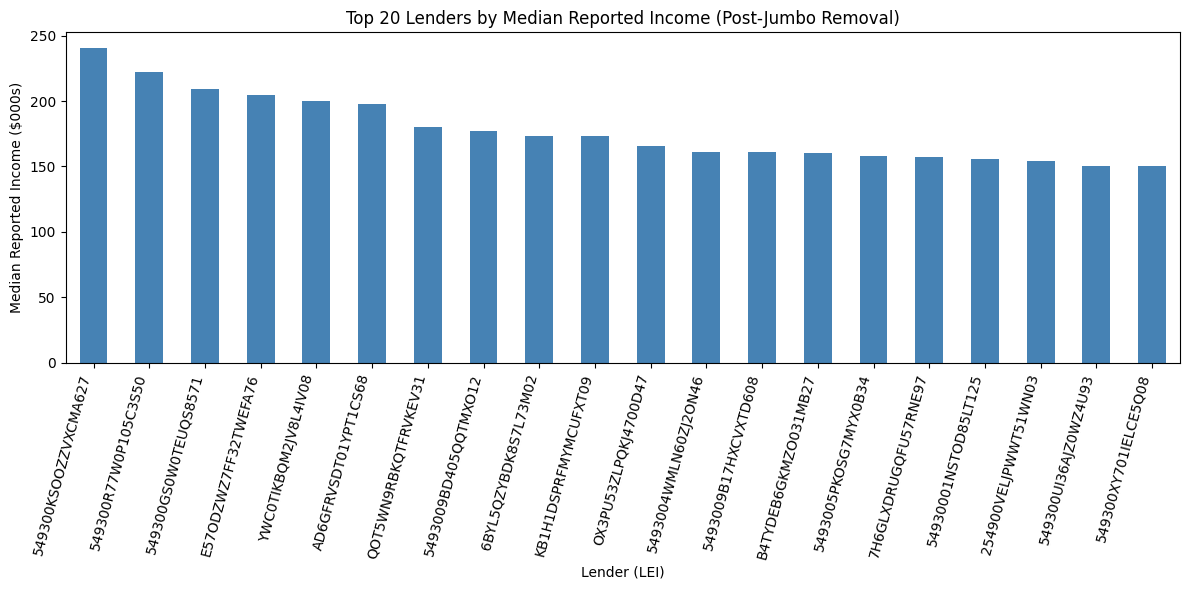

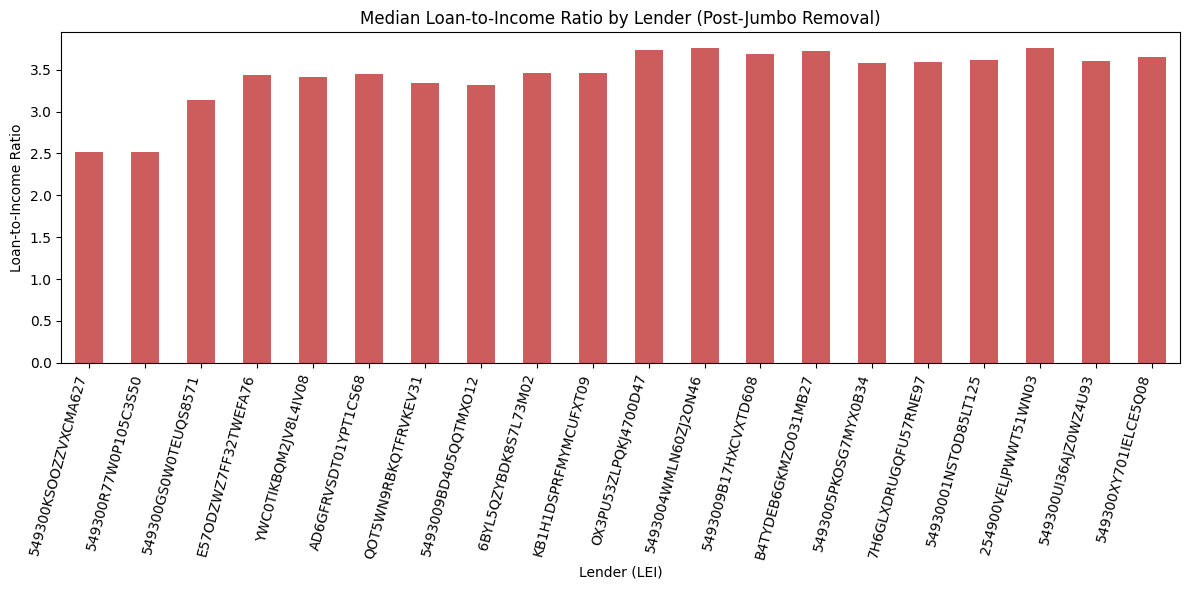

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# If not already done, store the result of the function:
df_non_jumbo = exclude_jumbo_loans(cohort)

# --- Compute loan-to-income ratio ---
df_non_jumbo["income"] = pd.to_numeric(df_non_jumbo["income"], errors="coerce")
df_non_jumbo["loan_to_income_ratio"] = df_non_jumbo["loan_amount"] / (df_non_jumbo["income"] * 1000)

# --- Group by lender (LEI) ---
lender_summary = (
    df_non_jumbo.groupby("lei")[["income", "loan_to_income_ratio"]]
    .median()
    .sort_values("income", ascending=False)
    .head(20)
)

# --- Plot 1: Median reported income per lender ---
plt.figure(figsize=(12, 6))
lender_summary["income"].plot(kind="bar", color="steelblue")
plt.title("Top 20 Lenders by Median Reported Income (Post-Jumbo Removal)")
plt.ylabel("Median Reported Income ($000s)")
plt.xlabel("Lender (LEI)")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()

# --- Plot 2: Median loan-to-income ratio per lender ---
plt.figure(figsize=(12, 6))
lender_summary["loan_to_income_ratio"].plot(kind="bar", color="indianred")
plt.title("Median Loan-to-Income Ratio by Lender (Post-Jumbo Removal)")
plt.ylabel("Loan-to-Income Ratio")
plt.xlabel("Lender (LEI)")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()

In [9]:
print("\n=== EDA SUMMARY ===")
print(f"Rows: {len(cohort):,}")
print(f"Approval Rate: {(cohort['action_taken'].isin([1, 2]).astype(int)).mean():.3f}")
print("\nRace Mix (%):")
print((cohort['race_group'].value_counts(normalize=True) * 100).round(2))
print("\nKey numeric summaries:")
cols = ["income", "income_ratio", "loan_to_value_ratio", "dti_clean", "rate_spread"]
print(cohort[cols].describe(percentiles=[0.1, 0.5, 0.9, 0.95, 0.99]))


=== EDA SUMMARY ===
Rows: 265,441
Approval Rate: 0.900

Race Mix (%):
race_group
White                               56.31
Asian                               32.69
Hispanic or Latino                   5.42
Black or African American            5.01
American Indian or Alaska Native     0.30
Pacific Islander                     0.27
Name: proportion, dtype: float64

Key numeric summaries:
              income   income_ratio  loan_to_value_ratio      dti_clean  \
count  265441.000000  263800.000000        265441.000000  265154.000000   
mean      183.938954       1.843972            81.896795      41.335982   
std       216.341912       2.139953            17.018823      10.049911   
min         1.000000       0.006039             1.576000      15.000000   
10%        70.000000       0.755149            59.583000      25.000000   
50%       137.000000       1.414566            84.545000      42.000000   
90%       321.000000       3.076256            97.000000      55.000000   
95%      

In [10]:
cohort[["income", "loan_to_value_ratio", "dti_clean", "race_group", "action_taken"]].isna().mean().sort_values()

income                 0.000000
loan_to_value_ratio    0.000000
race_group             0.000000
action_taken           0.000000
dti_clean              0.001081
dtype: float64

In [11]:
(
    cohort.assign(approved=(cohort["action_taken"].isin([1,2]).astype(int)))
    .groupby("race_group")["approved"]
    .mean()
    .sort_values()
    .to_frame("ApprovalRate")
)

,ApprovalRate
race_group,
Black or African American,0.848084
Hispanic or Latino,0.876174
Pacific Islander,0.879167
American Indian or Alaska Native,0.879203
Asian,0.894275
White,0.911072


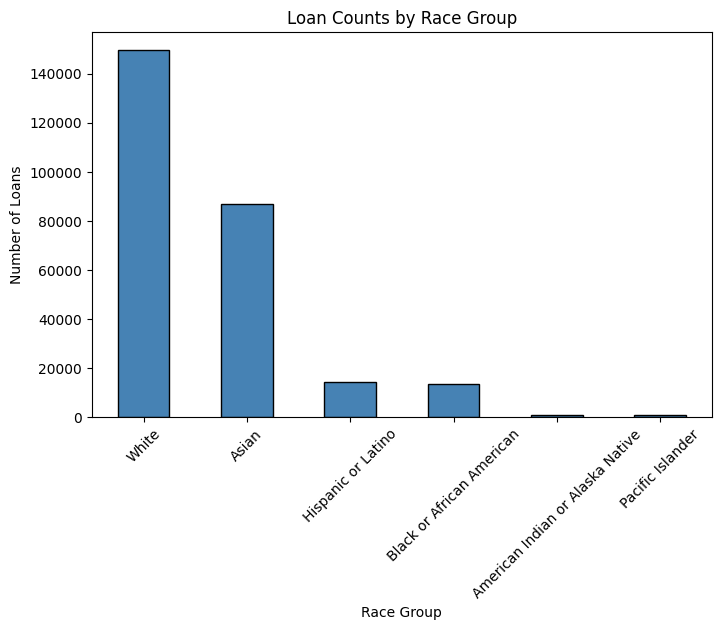

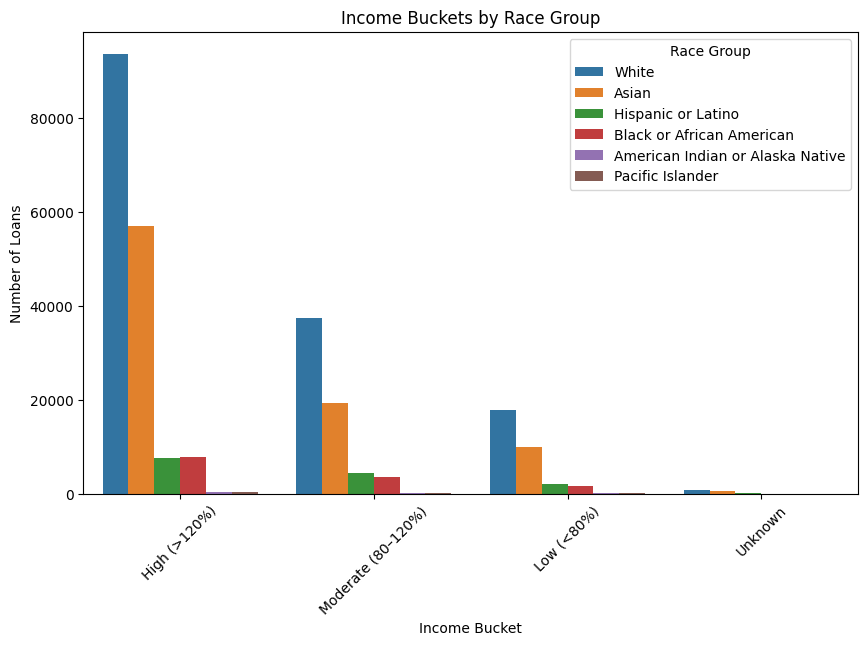

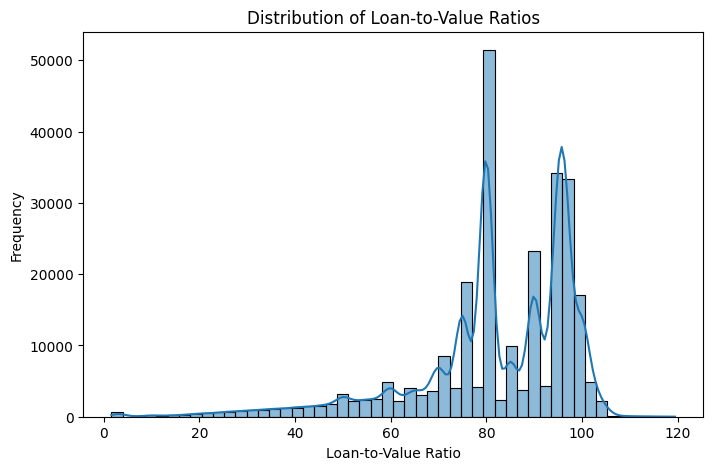

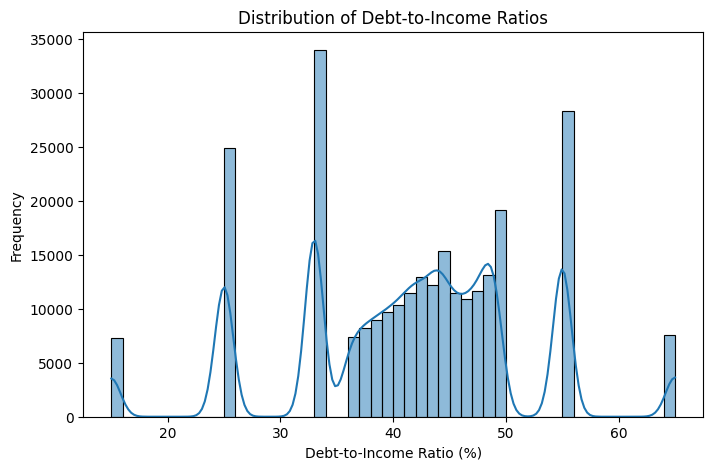

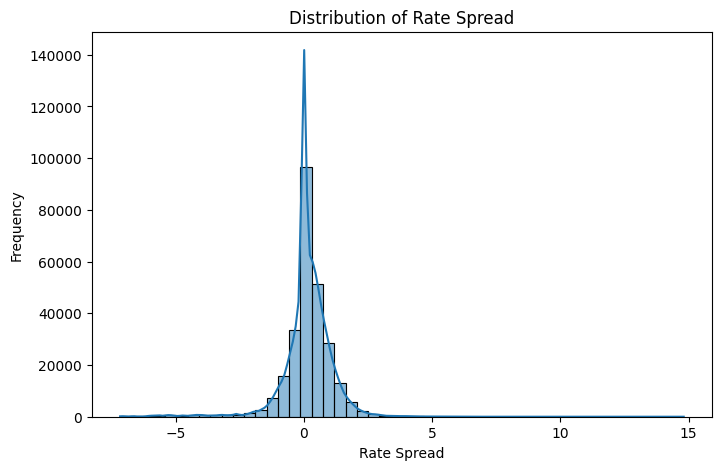

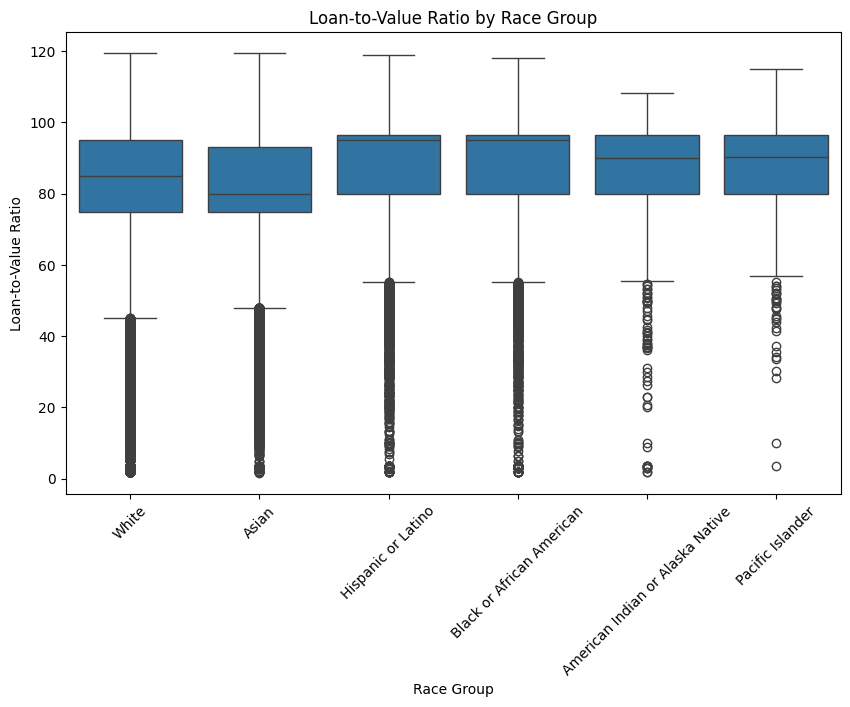

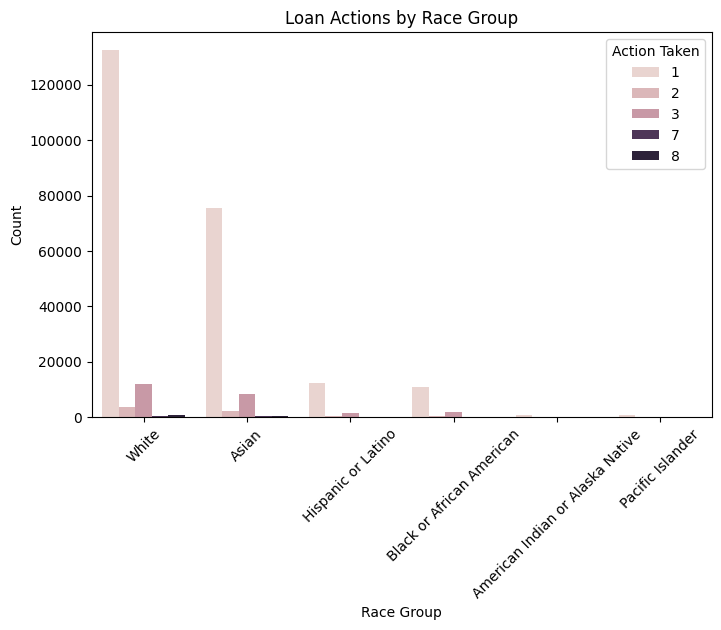

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Race Group Distribution
plt.figure(figsize=(8,5))
cohort["race_group"].value_counts().plot(kind="bar", color="steelblue", edgecolor="black")
plt.title("Loan Counts by Race Group")
plt.ylabel("Number of Loans")
plt.xlabel("Race Group")
plt.xticks(rotation=45)
plt.show()

# 2. Income Buckets by Race
plt.figure(figsize=(10,6))
sns.countplot(data=cohort, x="income_bucket", hue="race_group")
plt.title("Income Buckets by Race Group")
plt.ylabel("Number of Loans")
plt.xlabel("Income Bucket")
plt.xticks(rotation=45)
plt.legend(title="Race Group")
plt.show()

# 3. Loan-to-Value Ratio Distribution
plt.figure(figsize=(8,5))
sns.histplot(cohort["loan_to_value_ratio"], bins=50, kde=True)
plt.title("Distribution of Loan-to-Value Ratios")
plt.xlabel("Loan-to-Value Ratio")
plt.ylabel("Frequency")
plt.show()

# 4. Debt-to-Income Ratio Distribution
plt.figure(figsize=(8,5))
sns.histplot(cohort["dti_clean"], bins=50, kde=True)
plt.title("Distribution of Debt-to-Income Ratios")
plt.xlabel("Debt-to-Income Ratio (%)")
plt.ylabel("Frequency")
plt.show()

# 5. Rate Spread Distribution (can signal skew)
plt.figure(figsize=(8,5))
sns.histplot(cohort["rate_spread"], bins=50, kde=True)
plt.title("Distribution of Rate Spread")
plt.xlabel("Rate Spread")
plt.ylabel("Frequency")
plt.show()

# 6. Boxplot of LTV by Race Group
plt.figure(figsize=(10,6))
sns.boxplot(data=cohort, x="race_group", y="loan_to_value_ratio")
plt.title("Loan-to-Value Ratio by Race Group")
plt.ylabel("Loan-to-Value Ratio")
plt.xlabel("Race Group")
plt.xticks(rotation=45)
plt.show()

# 7. Approval proxy (action_taken) by race group
plt.figure(figsize=(8,5))
sns.countplot(data=cohort, x="race_group", hue="action_taken")
plt.title("Loan Actions by Race Group")
plt.ylabel("Count")
plt.xlabel("Race Group")
plt.xticks(rotation=45)
plt.legend(title="Action Taken")
plt.show()

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split

DATA_PROCESSED = "../data/processed"
os.makedirs(DATA_PROCESSED, exist_ok=True)

# From EDA
df = cohort.copy()

# Raw income is highly sckewed. Log-transormation to compress high income to prep for logistic regression
df["log_income"] = np.log1p(df["income"])

# Add Metro area dummies to control for location-level effects
df["msa_md"] = df["derived_msa-md"].astype("category")
df = pd.get_dummies(df, columns=["msa_md"], prefix="msa", drop_first=True)

# Add Purchaser type dummies to control for channels
df["purchaser_type"] = df["purchaser_type"].astype("category")
df = pd.get_dummies(df, columns=["purchaser_type"], prefix="purch", drop_first=True)

# Keep LEI as categorical for control for lender fixed effects
df["lei"] = df["lei"].astype("category")

# Keep only applications that resulted in an approval or denial
df = df[df["action_taken"].isin([1, 2, 3])].copy()

# Define binary outcome:
# 1 = approved/originated
# 0 = denied
df["approved"] = df["action_taken"].isin([1, 2]).astype(int)

print("Outcome distribution:")
print(df["approved"].value_counts(normalize=True).round(3))

df["race_group_original"] = cohort["race_group"]

# Convert categorical columsn into dummy variables
    #	White = baseline race
    #	<20% = baseline DTI bucket
    #	Low income (<80%) = baseline income bucket
df = pd.get_dummies(df, columns=["race_group", "dti_bucket", "income_bucket"], drop_first=True)


# Train/Test split stratified by approval outcome
train, test = train_test_split(df, test_size=0.3, stratify=df["approved"], random_state=42)

# Save full, train, and test datasets
out_full = os.path.join(DATA_PROCESSED, "hmda_ca2022_model_ready.csv")
out_train = os.path.join(DATA_PROCESSED, "hmda_ca2022_train.csv")
out_test = os.path.join(DATA_PROCESSED, "hmda_ca2022_test.csv")

df.to_csv(out_full, index=False)
train.to_csv(out_train, index=False)
test.to_csv(out_test, index=False)

# Print summary
print(f"Processed dataset saved:")
print(f"  Full:  {out_full} ({len(df)} rows)")
print(f"  Train: {out_train} ({len(train)} rows)")
print(f"  Test:  {out_test} ({len(test)} rows)")

print("\nApproval rate check (train vs test):")
print("Train:", train['approved'].mean())
print("Test :", test['approved'].mean())

# Sanity check
print("Approval rate overall:", df["approved"].mean().round(3))
print("\nApproval rate by race group:")
print(df.groupby("race_group_original")["approved"].mean().round(3))

Outcome distribution:
approved
1    0.909
0    0.091
Name: proportion, dtype: float64
Processed dataset saved:
  Full:  ../data/processed/hmda_ca2022_model_ready.csv (263002 rows)
  Train: ../data/processed/hmda_ca2022_train.csv (184101 rows)
  Test:  ../data/processed/hmda_ca2022_test.csv (78901 rows)

Approval rate check (train vs test):
Train: 0.9087022884177707
Test : 0.9086957072787417
Approval rate overall: 0.909

Approval rate by race group:
race_group_original
American Indian or Alaska Native    0.891
Asian                               0.903
Black or African American           0.857
Hispanic or Latino                  0.889
Pacific Islander                    0.888
White                               0.919
Name: approved, dtype: float64
